# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [1]:
from spacerocks import SpaceRock
import numpy as np

You can also pass in just a single object or an array of objects. I'll try BP519. Here I've turned on precision. This involves a non-vectorized solution to Kepler's equation to calculate the eccentric anomaly, and a topocentric correction to the Earth's position. Right now, only DECam is supported, but I'm working on implementing an obscode feature.

In [480]:
r0 = SpaceRock(a=388.567940, 
               e=0.951751, 
               inc=47.206, 
               arg=312.172, 
               node=158.091, 
               epoch=2462690.702, 
               tau=2457036.6,
               H=4.5, 
               name='tv',
               precise=True,
               input_coordinates='keplerian',
               input_frame='barycentric',
               input_angles='degrees',
               obscode='W84')

In [481]:
cov_kep = np.array([[ 1.8609e-01,  2.3470e-05, -8.9947e-08, -3.1292e-07, -5.0288e-06, -9.4697e-05],
[ 2.3470e-05,  2.9605e-09, -1.1393e-11, -3.9545e-11, -6.4132e-10, -1.1931e-08],
[-8.9947e-08, -1.1393e-11,  3.5136e-13,  1.1718e-12,  4.3526e-12,  4.3783e-11],
[-3.1292e-07, -3.9545e-11,  1.1718e-12,  3.9770e-12,  1.2768e-11,  1.5571e-10], 
[-5.0288e-06, -6.4132e-10,  4.3526e-12,  1.2768e-11,  3.2014e-10,  2.2239e-09], 
[-9.4697e-05, -1.1931e-08,  4.3783e-11,  1.5571e-10,  2.2239e-09,  4.9071e-08]])

In [482]:
J = np.linalg.inv(r0.jacobian)

#d_a = 0.0078527132767012304
#d_node = 0.00011397565932540869 
#d_e = 2.1797880078135241e-05
#d_i = 8.6080888604753787e-05 
#d_epoch = 0.24862051383178221 
#d_arg = 0.0015573146902426677
#
## a, e, i, node, arg, epoch
#errors = [d_a, d_e, d_i, d_node, d_arg, d_epoch]
#
#cov_kep = np.zeros([6, 6])
#for ii, val1 in enumerate(errors):
#    for jj, val2 in enumerate(errors):
#        cov_kep[ii, jj] = val1 * val2
        
cov_xyz = np.matmul(J, np.matmul(cov_kep, J.T))

sig_xx = cov_xyz[0, 0]
sig_yy = cov_xyz[1, 1]
sig_zz = cov_xyz[2, 2]
sig_xy = cov_xyz[0, 1]
sig_xz = cov_xyz[0, 2]
sig_yz = cov_xyz[1, 2]

x = r0.ecl_state[0]
y = r0.ecl_state[1]
z = r0.ecl_state[2]

dra_dx = (-y/(x**2 + y**2))
dra_dy = x/(x**2 + y**2)
dra_dz = 0

ddec_dx = - np.sign(r0.x) * np.sign(r0.z) * np.sqrt(((x**2 * z**2) / ((x**2 + y**2)*(x**2 + y**2 + z**2)**2)))
ddec_dy = - np.sign(r0.y) * np.sign(r0.z) * np.sqrt(((y**2 * z**2) / ((x**2 + y**2)*(x**2 + y**2 + z**2)**2)))
ddec_dz = np.sqrt(((x**2 + y**2) / (x**2 + y**2 + z**2)**2))

In [563]:
dra_dx[0]

-0.022013804607873524

In [560]:
jac = np.array([[dra_dx, dra_dy, 0, 0, 0, 0],
                [ddec_dx, ddec_dy, ddec_dz, 0, 0, 0]])

In [561]:
cov_radec = np.matmul(jac, np.matmul(cov_xyz, jac.T))
cov_radec

array([[array([2.54844578e-10]), array([-1.0270115e-10])],
       [array([-1.0270115e-10]), array([4.14430917e-11])]], dtype=object)

In [491]:
xx = cov_radec[0][0]*np.cos(r0.dec.rad)**2
xy = cov_radec[0][1]*np.cos(r0.dec.rad)
yy = cov_radec[1][1]
pos_angle = 0.5*np.arctan2(2.*xy,(xx-yy))
pos_angle = np.pi/2 - pos_angle     # convert to astronomy convention of measuring position angle North through East
bovasqrd  = (xx + yy - np.sqrt((xx-yy)**2 + (2*xy)**2)) / (xx + yy + np.sqrt((xx-yy)**2 + (2*xy)**2))
det = xx*yy-xy*xy
a = (det/bovasqrd)**(1/4) 
b = (det*bovasqrd)**(1/4)

In [543]:
U, s , Vh = np.linalg.svd(cov_radec) 
orient = np.arctan2(U[1,0],U[0,0])*180/np.pi

In [548]:
orient 

158.04711055886625

In [546]:
np.degrees(pos_angle)

array([114.34888555])

In [497]:
np.degrees(a)

array([0.00089422])

In [498]:
np.degrees(b)

array([1.22441048e-05])

In [499]:
np.degrees(pos_angle)

array([114.34888555])

In [467]:
{'dec': -0.07472841993306581, 'opp': 109.40747982653748, 'elong': 108.26099880688548, 
 'err': {'a': 0.1202744604652362, 'PA': 93.542246880712398, 'b': 0.039854163035020249}, 
 'ra': 0.7305863501167895}

{'dec': -0.07472841993306581,
 'opp': 109.40747982653748,
 'elong': 108.26099880688548,
 'err': {'a': 0.1202744604652362,
  'PA': 93.5422468807124,
  'b': 0.03985416303502025},
 'ra': 0.7305863501167895}

In [1]:
from spacerocks import SpaceRock

In [2]:
BP = SpaceRock(a=4.487673062316562E+02, 
               e=9.214543710796702E-01, 
               inc=5.411068217470999E+01, 
               arg=3.480587931444684E+02, 
               node=1.352131434907198E+02, 
               epoch=2.473015776611103E+06, 
               tau=2458982.5,
               H=4.5, 
               name='BP',
               precise=True,
               input_coordinates='keplerian',
               input_frame='barycentric',
               input_angles='degrees',
               obscode=304)

In [3]:
BP.ra.hms, BP.dec.dms

(hms_tuple(h=array([4.]), m=array([33.]), s=array([13.29383922])),
 dms_tuple(d=array([-31.]), m=array([-18.]), s=array([-31.14304392])))

In [40]:
# Barycentric:
# 2458982.500000000 = A.D. 2020-May-13 00:00:00.0000 TDB
#  EC= 9.214543710796702E-01 QR= 3.524871030684755E+01 IN= 5.411068217470999E+01
#  OM= 1.352131434907198E+02 W = 3.480587931444684E+02 Tp=  2473015.776611103211
#  N = 1.037441078395607E-04 MA= 3.585441302379153E+02 TA= 2.901471338857519E+02
#  A = 4.487673062316562E+02 AD= 8.622859021564648E+02 PR= 3.470076590342235E+06
#
# $$SOE
# 2458982.500000000, A.D. 2020-May-13 00:00:00.0000,
# X=1.580639409220872E+01,
# Y=2.634085915326679E+01,
# Z=-4.122486401689469E+01,
# VX=-2.654346366438451E-03,
# VY=8.305911427892275E-04,
# VZ=1.769516671619466E-03

In [30]:
BP.pandas_df()

,name,a,e,inc,arg,node,varpi,epoch,M,tau,...,ra,dec,skycoord,delta,ltt,phase_angle,elong,r,H,mag
0,BP,448.767306,0.921454,0.94441,6.074772,2.359915,2.151501,2473015.776611103,-0.02541,2458982.5,...,1.030308,-0.930397,"<SkyCoord (ICRS): (ra, dec) in deg\n (59.03...",51.41213,0.000813,0.019604,1.560455,51.411586,4.5,21.610633


In [29]:
BP.skycoord.ra.hms

hms_tuple(h=array([3.]), m=array([56.]), s=array([7.75132786]))

In [4]:
in_data, out_data = BP.propagate(np.array([2458981.5, 2458983.5]))

In [ ]:
BP.pandas_df()

In [ ]:
BP.astropy_table()

In [ ]:
BP.ra.hms, BP.dec.dms

In [ ]:
# geo    04 33 13.31    -31 18 31.2
# 304    04 33 13.30    -31 18 31.1

In [ ]:
N = 1000
rocks = SpaceRock(a=np.random.uniform(30, 40, N), 
                  e=np.random.uniform(0, 0.999, N), 
                  inc=np.random.rayleigh(np.pi/6, N), 
                  arg=np.random.uniform(0, 2*np.pi, N), 
                  node=np.random.uniform(0, 2*np.pi, N), 
                  epoch=np.random.uniform(2473015.5, 2483015.5, N),
                  tau=2458982.5 + np.random.rand(N)*365,
                  H=np.random.uniform(4, 7, N), 
                  name=['rock{}'.format(idx) for idx in range(N)],
                  precise=True,
                  input_coordinates='keplerian',
                  input_frame='barycentric',
                  input_angles='degrees')



In [ ]:
in_data, out_data = rocks.propagate(2459982.5)

In [505]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
import cartopy.crs as ccrs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [502]:
ra = r0.ra
dec = r0.dec

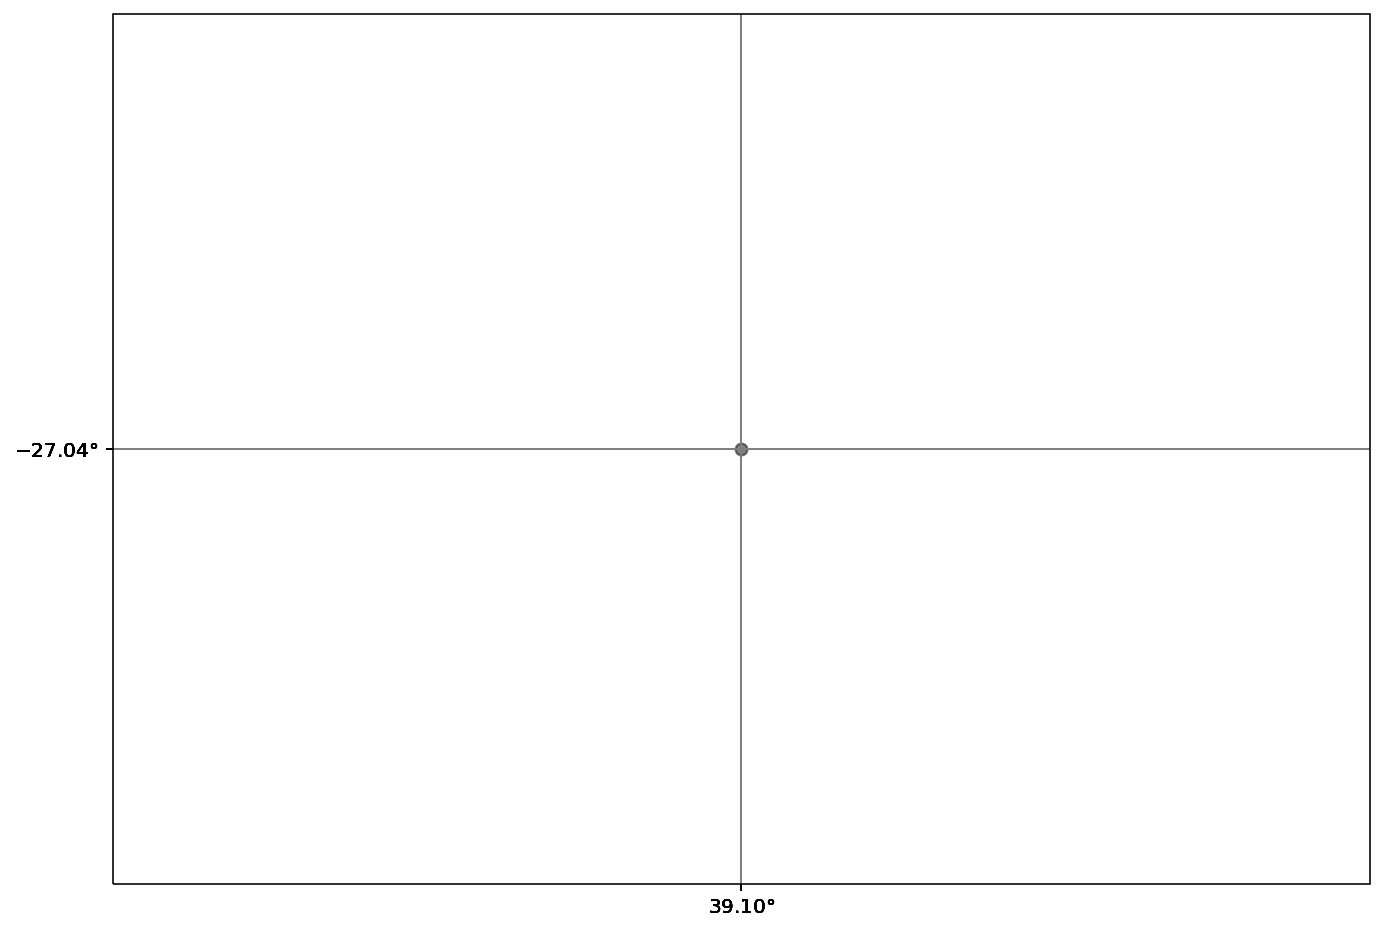

In [559]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

xdata = ra.degree
xdata[xdata > 180] -= 360

xmin=np.min(xdata)
xmax=np.max(xdata)
ymin=np.min(dec.degree)
ymax=np.max(dec.degree)

ax.scatter(-xdata, dec.degree, color='black', alpha=0.5, zorder=1)

xticks = np.linspace(-xmax, -xmin, 8)
yticks = np.linspace(ymin, ymax, 8)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
xticklabels = ['${:.2f}\degree$'.format(-value) for value in xticks]
yticklabels = ['${:.2f}\degree$'.format(value) for value in yticks]
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

e1 = patches.Ellipse((-ra.degree, dec.degree), np.degrees(a), np.degrees(b),
                     angle=np.degrees(pos_angle), linewidth=0, fill=True, 
                     zorder=0, alpha=0.5)

ax.add_patch(e1)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)


gl.bottom_labels = False
gl.top_labels = False
gl.left_labels = False
gl.right_labels = False

xrange = xmax - xmin
yrange = ymax - ymin

try:
    ax.set_extent([-xmax - xrange * 0.05, -xmin + xrange * 0.05,
                   ymin - yrange * 0.05, ymax + yrange * 0.05], crs=ccrs.PlateCarree())
except:
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

In [ ]:
{'dec': -0.07472841993306581, 'opp': 109.40747982653748, 'elong': 108.26099880688548, 'err': {'a': 0.1202744604652362, 'PA': 93.542246880712398, 'b': 0.039854163035020249}, 'ra': 0.7305863501167895}



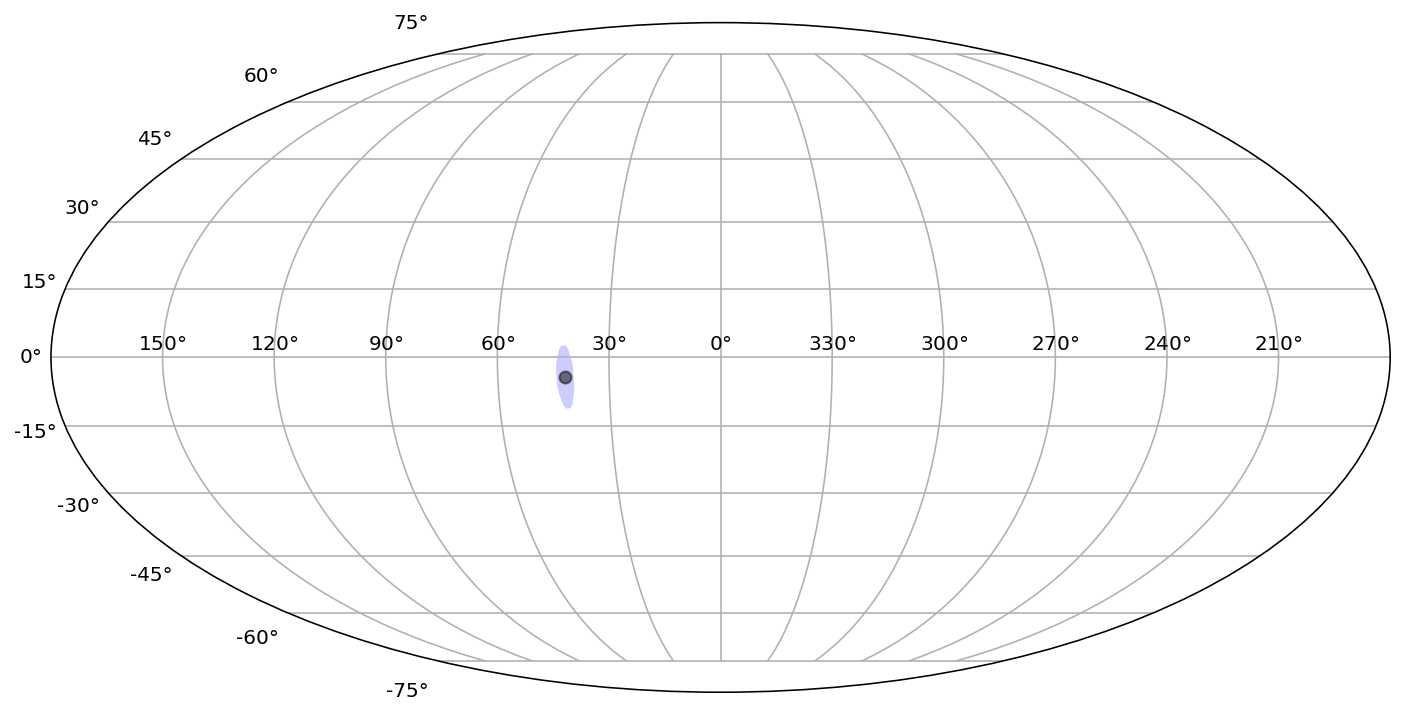

In [558]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)

xdata = ra.rad
xdata[xdata > np.pi] -= 2*np.pi
ax.set_xticklabels(['$150\degree$', '$120\degree$', '$90\degree$' ,
                    '$60\degree$' , '$30\degree$' , '$0\degree$'  ,
                    '$330\degree$', '$300\degree$', '$270\degree$',
                    '$240\degree$', '$210\degree$'])

e1 = patches.Ellipse((-0.7305863501167895, -0.07472841993306581), 2*0.1202744604652362, 2*0.039854163035020249,
                     angle=93.542246880712398, linewidth=0, fill=True, 
                     zorder=0, alpha=0.2, color='blue')

ax.add_patch(e1)

ax.scatter(-0.7305863501167895, -0.07472841993306581, color='black', alpha=0.5)

In [507]:
xcenter, ycenter = 0.38, 0.52
width, height = 1e-1, 3e-1
angle = -30

theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
x = 0.5 * width * np.cos(theta)
y = 0.5 * height * np.sin(theta)

rtheta = np.radians(angle)
R = np.array([
    [np.cos(rtheta), -np.sin(rtheta)],
    [np.sin(rtheta),  np.cos(rtheta)],
    ])


x, y = np.dot(R, np.array([x, y]))
x += xcenter
y += ycenter

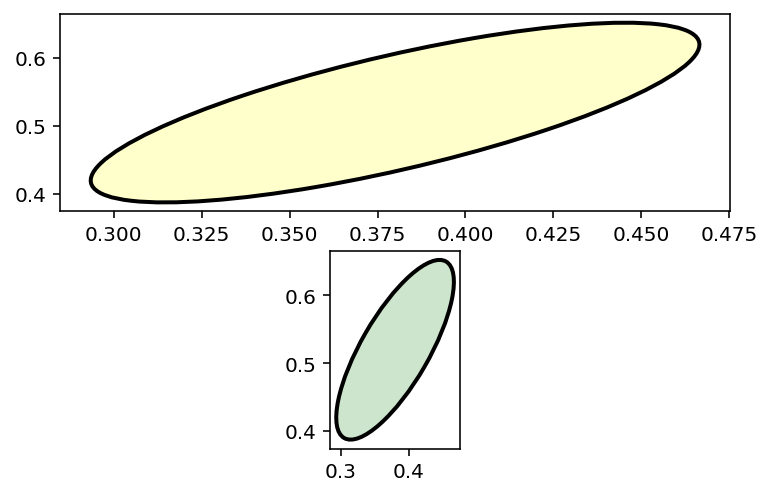

In [508]:
fig = plt.figure()
ax = fig.add_subplot(211, aspect='auto')
ax.fill(x, y, alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e1 = patches.Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=2, fill=False, zorder=2)

ax.add_patch(e1)

ax = fig.add_subplot(212, aspect='equal')
ax.fill(x, y, alpha=0.2, facecolor='green', edgecolor='green', zorder=1)
e2 = patches.Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=2, fill=False, zorder=2)


ax.add_patch(e2)
fig.savefig('ellipse_compare')